20BAI1071
VINITHI K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras.layers import LSTM, Dense, Dropout, Flatten
from  keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import glob
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4182, done.
remote: Counting objects: 100% (510/510), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 4182 (delta 2), reused 502 (delta 0), pack-reused 3672
Receiving objects: 100% (4182/4182), 30.44 MiB | 30.24 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [ ]:
SEED = 2017
DATA_DIR = '/content/free-spoken-digit-dataset/recordings/'

In [ ]:
files = glob.glob(DATA_DIR + "*.wav")
X_train, X_val = train_test_split(files, test_size = 0.2, random_state = SEED)

print("# Training Examples: {}".format(len(X_train)))
print("# Validation Examples: {}".format(len(X_val)))

# Training Examples: 2400
# Validation Examples: 600


In [ ]:
labels = []

for i in range(len(X_train)):
  label = X_train[i].split("/")[-1].split("_")[1]
  if label not in labels:
    labels.append(label)
print(labels)

['yweweler', 'theo', 'lucas', 'jackson', 'george', 'nicolas']


In [ ]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(list(set(labels)))

def one_hot_encode(x): return label_binarizer.transform(x)

In [ ]:
n_features = 20
max_length = 80
n_classes = len(labels)

In [ ]:
def batch_generator(data, batch_size=16):
  while 1:
    random.shuffle(data)
    X, y = [], []
    for i in range(batch_size):
      wav = data[i]
      wave, sr = librosa.load(wav, mono=True)
      label = wav.split('/')[-1].split('_')[1]
      y.append(label)
      mfcc = librosa.feature.mfcc(wave, sr)
      mfcc = np.pad(mfcc, ((0,0), (0, max_length-len(mfcc[0]))), mode='constant', constant_values=0)
      X.append(np.array(mfcc))
    yield np.array(X), np.array(one_hot_encode(y))


In [ ]:
learning_rate = 0.001
batch_size = 64
n_epochs = 5
dropout = 0.5

input_shape = (n_features,max_length)
steps_per_epoch = 10

In [ ]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=input_shape,
dropout=dropout))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_classes, activation='softmax'))

In [ ]:
opt = Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 256)           345088    
_________________________________________________________________
flatten_5 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               655488    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
Total params: 1,001,350
Trainable params: 1,001,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!pip install h5py

In [ ]:
history = model.fit_generator(
    generator = batch_generator(X_train, batch_size),
    steps_per_epoch = steps_per_epoch,
    epochs = n_epochs,
    verbose = 1,
    validation_data = batch_generator(X_val,32),
    validation_steps = 5,
    callbacks = callbacks
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
10/10 [==============================] - 30s 3s/step - loss: 0.2660 - accuracy: 0.9031 - val_loss: 0.2954 - val_accuracy: 0.9250
Epoch 2/5
10/10 [==============================] - 30s 3s/step - loss: 0.2848 - accuracy: 0.8953 - val_loss: 0.2381 - val_accuracy: 0.9187
Epoch 3/5
10/10 [==============================] - 29s 3s/step - loss: 0.2784 - accuracy: 0.9047 - val_loss: 0.2201 - val_accuracy: 0.9500
Epoch 4/5
10/10 [==============================] - 29s 3s/step - loss: 0.2484 - accuracy: 0.9203 - val_loss: 0.1978 - val_accuracy: 0.9563
Epoch 5/5
10/10 [==============================] - 29s 3s/step - loss: 0.2516 - accuracy: 0.9047 - val_loss: 0.1286 - val_accuracy: 0.9750


In [ ]:
def testSample(filename,model):
  print(filename)
  max_length = 80
  wave, sr = librosa.load(filename, mono=True)
  mfcc = librosa.feature.mfcc(wave, sr)
  if(len(mfcc[0]) < 60 ):
    mfcc = np.pad(mfcc, ((0,0), (0, max_length-len(mfcc[0]))), mode='constant', constant_values=0)
    X = np.array([np.array(mfcc)])
    label = filename.split('/')[-1].split('_')[1]
    pred = model.predict(X)
    pred = np.round(pred,decimals=1)
    pred = label_binarizer.inverse_transform(pred)
    print("Actual Label: ",label)
    print("Predicted Label: ",pred)
  else:
    print("Incompatible Audio")

In [ ]:
testSample(files[600],model)

/content/free-spoken-digit-dataset/recordings/0_jackson_19.wav
Actual Label:  jackson
Predicted Label:  ['jackson']


In [ ]:
random.shuffle(files)
X, y = [], []
checkpoint = 0
for i in range(len(files)):
    wav = files[i]
    wave, sr = librosa.load(wav, mono=True)
    mfcc = librosa.feature.mfcc(wave, sr)
    if(len(mfcc[0]) < 80 ):
      mfcc = np.pad(mfcc, ((0,0), (0, max_length-len(mfcc[0]))), mode='constant', constant_values=0)
      X.append(np.array(mfcc))
      label = wav.split('/')[-1].split('_')[1]
      y.append(label)
      checkpoint+=1
    if(checkpoint%100 ==0):
      print("Current Data count Processed: ",checkpoint)

Current Data count Processed:  100
Current Data count Processed:  200
Current Data count Processed:  300
Current Data count Processed:  400
Current Data count Processed:  500
Current Data count Processed:  600
Current Data count Processed:  700
Current Data count Processed:  800
Current Data count Processed:  900
Current Data count Processed:  1000
Current Data count Processed:  1100
Current Data count Processed:  1200
Current Data count Processed:  1300
Current Data count Processed:  1400
Current Data count Processed:  1500
Current Data count Processed:  1600
Current Data count Processed:  1700
Current Data count Processed:  1800
Current Data count Processed:  1900
Current Data count Processed:  2000
Current Data count Processed:  2100
Current Data count Processed:  2200
Current Data count Processed:  2300
Current Data count Processed:  2400
Current Data count Processed:  2500
Current Data count Processed:  2600
Current Data count Processed:  2700
Current Data count Processed:  2800
C

In [ ]:
!git clone https://github.com/Ralireza/spoken-digit-recognition.git

Cloning into 'spoken-digit-recognition'...
remote: Enumerating objects: 1588, done.
remote: Total 1588 (delta 0), reused 0 (delta 0), pack-reused 1588
Receiving objects: 100% (1588/1588), 7.07 MiB | 29.93 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
import glob
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: WavFileWarning: Chunk (non-data) not understood, skipping it.


confusion_matrix:

 [[30  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 27  0  0  0  3  0  0]
 [ 0  1  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 29  0  0  0  1]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 29  0  1]
 [ 0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
----------------------------------------------------------
----------------------------------------------------------

classification_report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.97      1.00      0.98        30
           2       1.00      1.00      1.00        30
           3       1.00      0.90      0.95        30
           4       1.00      0.97      0.98        30
           5       1.00      0.97      0.98        30
           6       1.00      1.00      1.00        30
           7       0.91      0.97      0.94        30
           8      

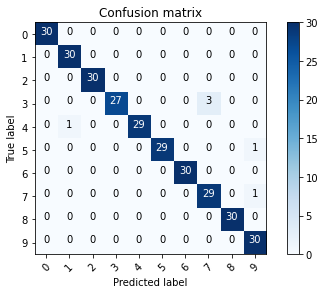



predicted spoken digit for a person:  [0]


In [ ]:
def build_dataset(sound_path='/content/spoken-digit-recognition/spoken_digit/'):
    files = sorted(os.listdir(sound_path))
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    data = dict()
    i = 0

    for f in files:
        feature = feature_extractor(sound_path=sound_path + f)
        if i % 5 == 0:
            x_test.append(feature)
            y_test.append(int(f[0]))
        else:
            x_train.append(feature)
            y_train.append(f[0])
        i += 1

    for i in range(0, len(x_train), len(x_train) // 10):
        data[y_train[i]] = x_train[i:i + len(x_train) // 10]
    return x_train, y_train, x_test, y_test, data


def feature_extractor(sound_path):
    sampling_freq, audio = wavfile.read(sound_path)
    mfcc_features = mfcc(audio, sampling_freq)

    return mfcc_features


def train_model(data):
    learned_hmm = dict()
    for label in data.keys():
        model = hmm.GMMHMM(n_components=14)
        feature = np.ndarray(shape=(1, 13))
        for list_feature in data[label]:
            feature = np.vstack((feature, list_feature))
        obj = model.fit(feature)
        learned_hmm[label] = obj
    return learned_hmm


def prediction(test_data, trained):
    # predict list of test
    predict_label = []
    if type(test_data) == type([]):
        for test in test_data:
            scores = []
            for node in trained.keys():
                scores.append(trained[node].score(test))
            predict_label.append(scores.index(max(scores)))
    # predict a test
    else:
        scores = []
        for node in trained.keys():
            scores.append(trained[node].score(test_data))
        predict_label.append(scores.index(max(scores)))
    return predict_label


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def report(y_test, y_pred, show_cm=True):
    print("confusion_matrix:\n\n", confusion_matrix(y_test, y_pred))
    print("----------------------------------------------------------")
    print("----------------------------------------------------------\n")
    print("classification_report:\n\n", classification_report(y_test, y_pred))
    print("----------------------------------------------------------")
    print("----------------------------------------------------------\n")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("----------------------------------------------------------")
    print("----------------------------------------------------------\n")
    if show_cm:
        plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


x_train, y_train, x_test, y_test, data = build_dataset()
with open("/content/spoken-digit-recognition/learned.pkl", "rb") as file:
    learned_hmm = pickle.load(file)
single_test = feature_extractor('/content/spoken-digit-recognition/spoken_digit/0_jackson_19.wav')


y_pred = prediction(x_test, learned_hmm)
report(y_test, y_pred, show_cm=True)
y_pred_final = prediction(single_test, learned_hmm)
print("\n")
print("predicted spoken digit for a person: ",y_pred_final)